# Analyzing Facebook Data Networks
+ our data was taken from [Stanford](https://snap.stanford.edu/data/ego-Facebook.html)
+ The data contains 4039 nodes with nearly 90k edges

# Workflow
+ Display our files
+ Figure out how to join files( over 20 files)
+ Build dictionary to store attributes
+ Build network nodes and edges
+ build centrality scores
+ Build separate male/female dataframes and run t tests on centrality scores
+ Visual display of network by gender and of network by location

In [87]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np

SyntaxError: invalid syntax (<ipython-input-87-dc3d1fae157d>, line 6)

# Read in Data
<p style="font-family: times, serif; font-size:14pt">Data comes as a tar file. I opted to just load files into pandas instead of attempting to unwrap that tar file in python. We have a file containing all of the edges, facebook.csv. We also have 10 .feat and 10 .featname files. We need to figure out a way to map these two datasets to each other</p>


## .feat   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         .featname

In [55]:
example= pd.read_csv('0.feat',sep=" ",header=None)
print(example.shape)
example.head()

(347, 225)


0    1    2    3    4    5    6    7    8    9   ...   215  216  217  218  \
0    1    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
1    2    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
2    3    0    0    0    0    0    0    0    1    0 ...     0    0    0    1   
3    4    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
4    5    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   

   219  220  221  222  223  224  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 225 columns]

In [88]:
example= pd.read_csv('0.featnames',sep=" ",header=None)
print(example.shape)
example.head()

(224, 4)


0                    1        2  3
0  0  birthday;anonymized  feature  0
1  1  birthday;anonymized  feature  1
2  2  birthday;anonymized  feature  2
3  3  birthday;anonymized  feature  3
4  4  birthday;anonymized  feature  4

# Solution
<p style="font-family: times, serif; font-size:14pt">extract the featnames from .featnames and insert it into  the featnames files and use those as our column names. Then create a joined dataset with all 10 .feat files</p>




In [2]:
names=["0","107","1684","1912","3437",'348',"3980","414","686","698"]
feat_file_names= [x+".feat" for x in names]
featnames_filenames=[x+".featnames" for x in names]

In [3]:
df_list = []
for i in range(len(feat_file_names)):
    c_df = pd.read_csv(feat_file_names[i], header=None, sep=' ')
    c = pd.read_csv(featnames_filenames[i], header=None,)[0].tolist()
    c2 = []
    for j in range(len(c)):
        c2.append(' '.join(c[j].split(' ')[1:]))
    nodes = c_df[0].tolist()
    c_df = c_df.drop(columns=[0])
    c = {v: k for v, k in enumerate(c2,1)}
    c_df = c_df.rename(columns=c)
    c_df.index = nodes
    df_list.append(c_df)

In [60]:
## type check
[type(x) for x in df_list]

[pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame]

## Build a dictionary which looks at the above list of df's and extracts the values of each row

In [5]:
my_nodes={}
for node in range(0,4039):
    my_nodes.setdefault(node, [])

for x in df_list:
    for node in range(0,4039):
        for i in x.index:
            if i==node:
                my_nodes[node].append(x.loc[node,])


## Use facebook.combined.txt file to build out our network edges

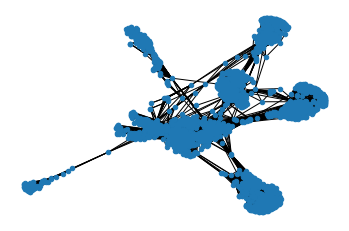

In [6]:
#Create our graph object and display
F = nx.read_edgelist('facebook_combined.txt',
                     create_using=nx.Graph(),
                     nodetype=int)

for i in range(1,len(my_nodes)+1):
    try:        
        for j in range(len(my_nodes[i][0])):
            if my_nodes[i][0].values[j]==1:
                a = ' '.join(' '.join(my_nodes[i][0].index[j].split(' ')[:-2]).split(';')[:-1])
                F.nodes[i][a] = my_nodes[i][0].index[j].split(' ')[-1]
    except:
        pass

plt.axis('off')
nx.draw_networkx(F, with_labels=False, node_size=20) 

## Build centrality scores

In [9]:

dc = nx.degree_centrality(F)
bc = nx.betweenness_centrality(F)
ec = nx.eigenvector_centrality(F)


def deg_df(data,col):
    df = pd.DataFrame(sorted(data.items()),columns=['nodes',col])
    return df
deg = deg_df(dc,'deg_centrality')
bet = deg_df(bc,'bet_centrality')
eig = deg_df(ec,'eig_centrality')

main_df = pd.merge(deg,bet,on='nodes',how='outer')
main_df = pd.merge(main_df,eig,on='nodes',how='outer')
main_df.head()    
    

nodes  deg_centrality  bet_centrality  eig_centrality
0      0        0.085934    1.463059e-01    3.391796e-05
1      1        0.004210    2.783274e-06    6.045346e-07
2      2        0.002476    7.595021e-08    2.233461e-07
3      3        0.004210    1.685066e-06    6.635648e-07
4      4        0.002476    1.840332e-07    2.236416e-07

## Rebuild columns values

In [10]:
var1 = []
for i in range(1,len(my_nodes)+1):
    try:        
        for j in range(len(my_nodes[i][0].index)):
            var1.append(' '.join(' '.join(my_nodes[i][0].index[j].split(' ')[:-2]).split(';')[:-1]))
    except:
        pass

In [11]:
cols = pd.DataFrame(var1)[0].unique().tolist()
cols

['birthday',
 'education classes id',
 'education concentration id',
 'education degree id',
 'education school id',
 'education type',
 'education with id',
 'education year id',
 'first_name',
 'gender',
 'hometown id',
 'languages id',
 'last_name',
 'locale',
 'location id',
 'work employer id',
 'work end_date',
 'work location id',
 'work position id',
 'work start_date',
 'work with id',
 'middle_name',
 'work from id',
 'work projects id',
 'name',
 'political',
 'religion']

## Build out new df which isn't hot encoded and instead uses the feature_value as the value

In [12]:
for c in cols:
    df = pd.DataFrame(columns=['nodes',c])
    for n in range(len(F.nodes)):
        if c in F.nodes[n]:
            df1 = pd.DataFrame([[n,F.nodes[n][c]]],columns=['nodes',c])
            df = df.append(df1)
    df.nodes = df.nodes.astype(str)
    main_df.nodes= main_df.nodes.astype(str)
    main_df = pd.merge(main_df,df,on='nodes',how='outer')
main_df.nodes=main_df.nodes.astype(int)

In [62]:
main_df.head()

nodes  deg_centrality  bet_centrality  eig_centrality birthday  \
0      0        0.085934    1.463059e-01    3.391796e-05      NaN   
1      1        0.004210    2.783274e-06    6.045346e-07      NaN   
2      2        0.002476    7.595021e-08    2.233461e-07      NaN   
3      3        0.004210    1.685066e-06    6.635648e-07        7   
4      4        0.002476    1.840332e-07    2.236416e-07      NaN   

  education classes id education concentration id education degree id  \
0                  NaN                        NaN                 NaN   
1                  NaN                        NaN                 NaN   
2                  NaN                        NaN                 NaN   
3                  NaN                         14                 NaN   
4                  NaN                        NaN                 NaN   

  education school id education type   ...    work location id  \
0                 NaN            NaN   ...                 NaN   
1                 NaN            NaN   ...                 NaN   
2                  35             55   ...                 NaN   
3                  50             55   ...                 137   
4                  50             55   ...                 NaN   

  work position id work start_date work with id middle_name work from id  \
0              NaN             NaN          NaN         NaN          NaN   
1              NaN             NaN          NaN         NaN          NaN   
2              NaN             NaN          NaN         NaN          NaN   
3              NaN             202          NaN         NaN          NaN   
4              NaN             NaN          NaN         NaN          NaN   

  work projects id name political religion  
0              NaN  NaN       NaN      NaN  
1              NaN  NaN       NaN      NaN  
2              NaN  NaN       NaN      NaN  
3              NaN  NaN       NaN      NaN  
4              NaN  NaN       NaN      NaN  

[5 rows x 31 columns]

**Add attributes to network**

In [63]:
node_attr = main_df.set_index("nodes").to_dict("index")
nx.set_node_attributes(F, node_attr)
F.node[10]

{'birthday': '6',
 'education concentration id': '14',
 'education school id': '50',
 'education type': '55',
 'education year id': '65',
 'gender': '78',
 'locale': '127',
 'location id': '137',
 'work employer id': '50',
 'work end_date': '157',
 'work start_date': '200',
 'deg_centrality': 0.0024764735017335313,
 'bet_centrality': 4.986739552037655e-08,
 'eig_centrality': 7.70856704409262e-07,
 'education classes id': nan,
 'education degree id': nan,
 'education with id': nan,
 'first_name': nan,
 'hometown id': nan,
 'languages id': nan,
 'last_name': nan,
 'work location id': nan,
 'work position id': nan,
 'work with id': nan,
 'middle_name': nan,
 'work from id': nan,
 'work projects id': nan,
 'name': nan,
 'political': nan,
 'religion': nan}

# use gender to look at centrality relations
+ Are women more central to the network
    + subset our centrality measures
    + the dataset contains two values for gender, presumably Male/Female. For the purpose of discussion we will assume 77 is male and 78 is female

In [14]:
males=main_df[main_df.gender=='77']
females=main_df[main_df.gender=='78']

**Males only DF**

In [15]:
males.describe()

nodes  deg_centrality  bet_centrality  eig_centrality
count  1531.000000     1531.000000    1.531000e+03    1.531000e+03
mean   2058.509471        0.011248    1.288912e-04    5.516243e-03
std    1127.150549        0.012285    2.480575e-03    1.815048e-02
min       1.000000        0.000248    0.000000e+00    6.385265e-14
25%    1124.500000        0.002724    2.980404e-07    5.300530e-08
50%    2126.000000        0.006191    2.442927e-06    1.543442e-06
75%    2980.500000        0.015354    1.257565e-05    8.403062e-05
max    4036.000000        0.055473    9.631033e-02    8.517341e-02

**Females only DF**

In [16]:
females.describe()

nodes  deg_centrality  bet_centrality  eig_centrality
count  2419.000000     2419.000000    2.419000e+03    2.419000e+03
mean   1987.963621        0.010468    7.516402e-04    2.795678e-03
std    1183.277575        0.012661    1.298043e-02    1.288163e-02
min       2.000000        0.000248    0.000000e+00    6.385265e-14
25%     972.000000        0.002724    4.999321e-07    5.589230e-08
50%    1922.000000        0.006439    3.339735e-06    9.487325e-07
75%    3033.500000        0.013621    1.690140e-05    9.801993e-06
max    4038.000000        0.258791    4.805181e-01    8.698328e-02

**Difference**

In [17]:
males.describe()-females.describe()

nodes  deg_centrality  bet_centrality  eig_centrality
count -888.000000     -888.000000   -8.880000e+02   -8.880000e+02
mean    70.545850        0.000780   -6.227490e-04    2.720564e-03
std    -56.127025       -0.000376   -1.049985e-02    5.268853e-03
min     -1.000000        0.000000    0.000000e+00    0.000000e+00
25%    152.500000        0.000000   -2.018917e-07   -2.886992e-09
50%    204.000000       -0.000248   -8.968074e-07    5.947090e-07
75%    -53.000000        0.001734   -4.325754e-06    7.422862e-05
max     -2.000000       -0.203318   -3.842077e-01   -1.809869e-03

## Initial observation of differences 
+ out of 4k or so nodes, there are a significantly larger amount of females(2419 versus 1531)
+ We can see above that there are differences in the means, however, we need to run a t test to test those differences for significance
+ Below I run t tests on all 3 centrality statistics based upon the null hypothesis that there is no gender based differences in averages

In [64]:
var_a = males.deg_centrality.var(ddof=1)
var_b = females.deg_centrality.var(ddof=1)


In [65]:
## T tests
mean_scores=pd.DataFrame(np.nan, index=[], columns=["T","P","Centrality_method"])
for col in main_df.columns[1:4]:
    t2, p2 = stats.ttest_ind(males[col],females[col])
    mean_scores=mean_scores.append({"T":t2,"P":p2,"Centrality_method":col}, ignore_index=True)
mean_scores.round(4)  


#t2, p2 = stats.ttest_ind(males.deg_centrality,females.deg_centrality)
#print("t = " + str(t2))
#print("p = " + str(p2))

T       P Centrality_method
0  1.9083  0.0564    deg_centrality
1 -1.8558  0.0636    bet_centrality
2  5.5013  0.0000    eig_centrality

+ We can see above that degree centrality is right on the threshold for our t test.  it seems very likely that the scores are in fact different by gender
+ In terms of between centrality, once again we are right on the threshold
+ In terms of eigen vector centrality our test comes back with strong confidence that there is a difference between the average eigen vector score by gender
+ Still the mean isn't neccesarrily the best approach, considering it isn't robust to outliers.  

## Look at Median values

In [22]:
med_scores=pd.DataFrame(np.nan, index=[], columns=["P","Median","Centrality_method"])
for col in main_df.columns[1:4]:
    print(col)
    stat, p, med, tbl = stats.median_test(males[col],females[col])
    print (p)
    med_scores=med_scores.append({"P":p,"Median":med,"Centrality_method":col}, ignore_index=True)
med_scores    

deg_centrality
0.3788277603565341
bet_centrality
0.0021414746694234646
eig_centrality
0.5566338876049259


P    Median Centrality_method
0  0.378828  0.006191    deg_centrality
1  0.002141  0.000003    bet_centrality
2  0.556634  0.000001    eig_centrality

# Graphs

**Network with node labels**

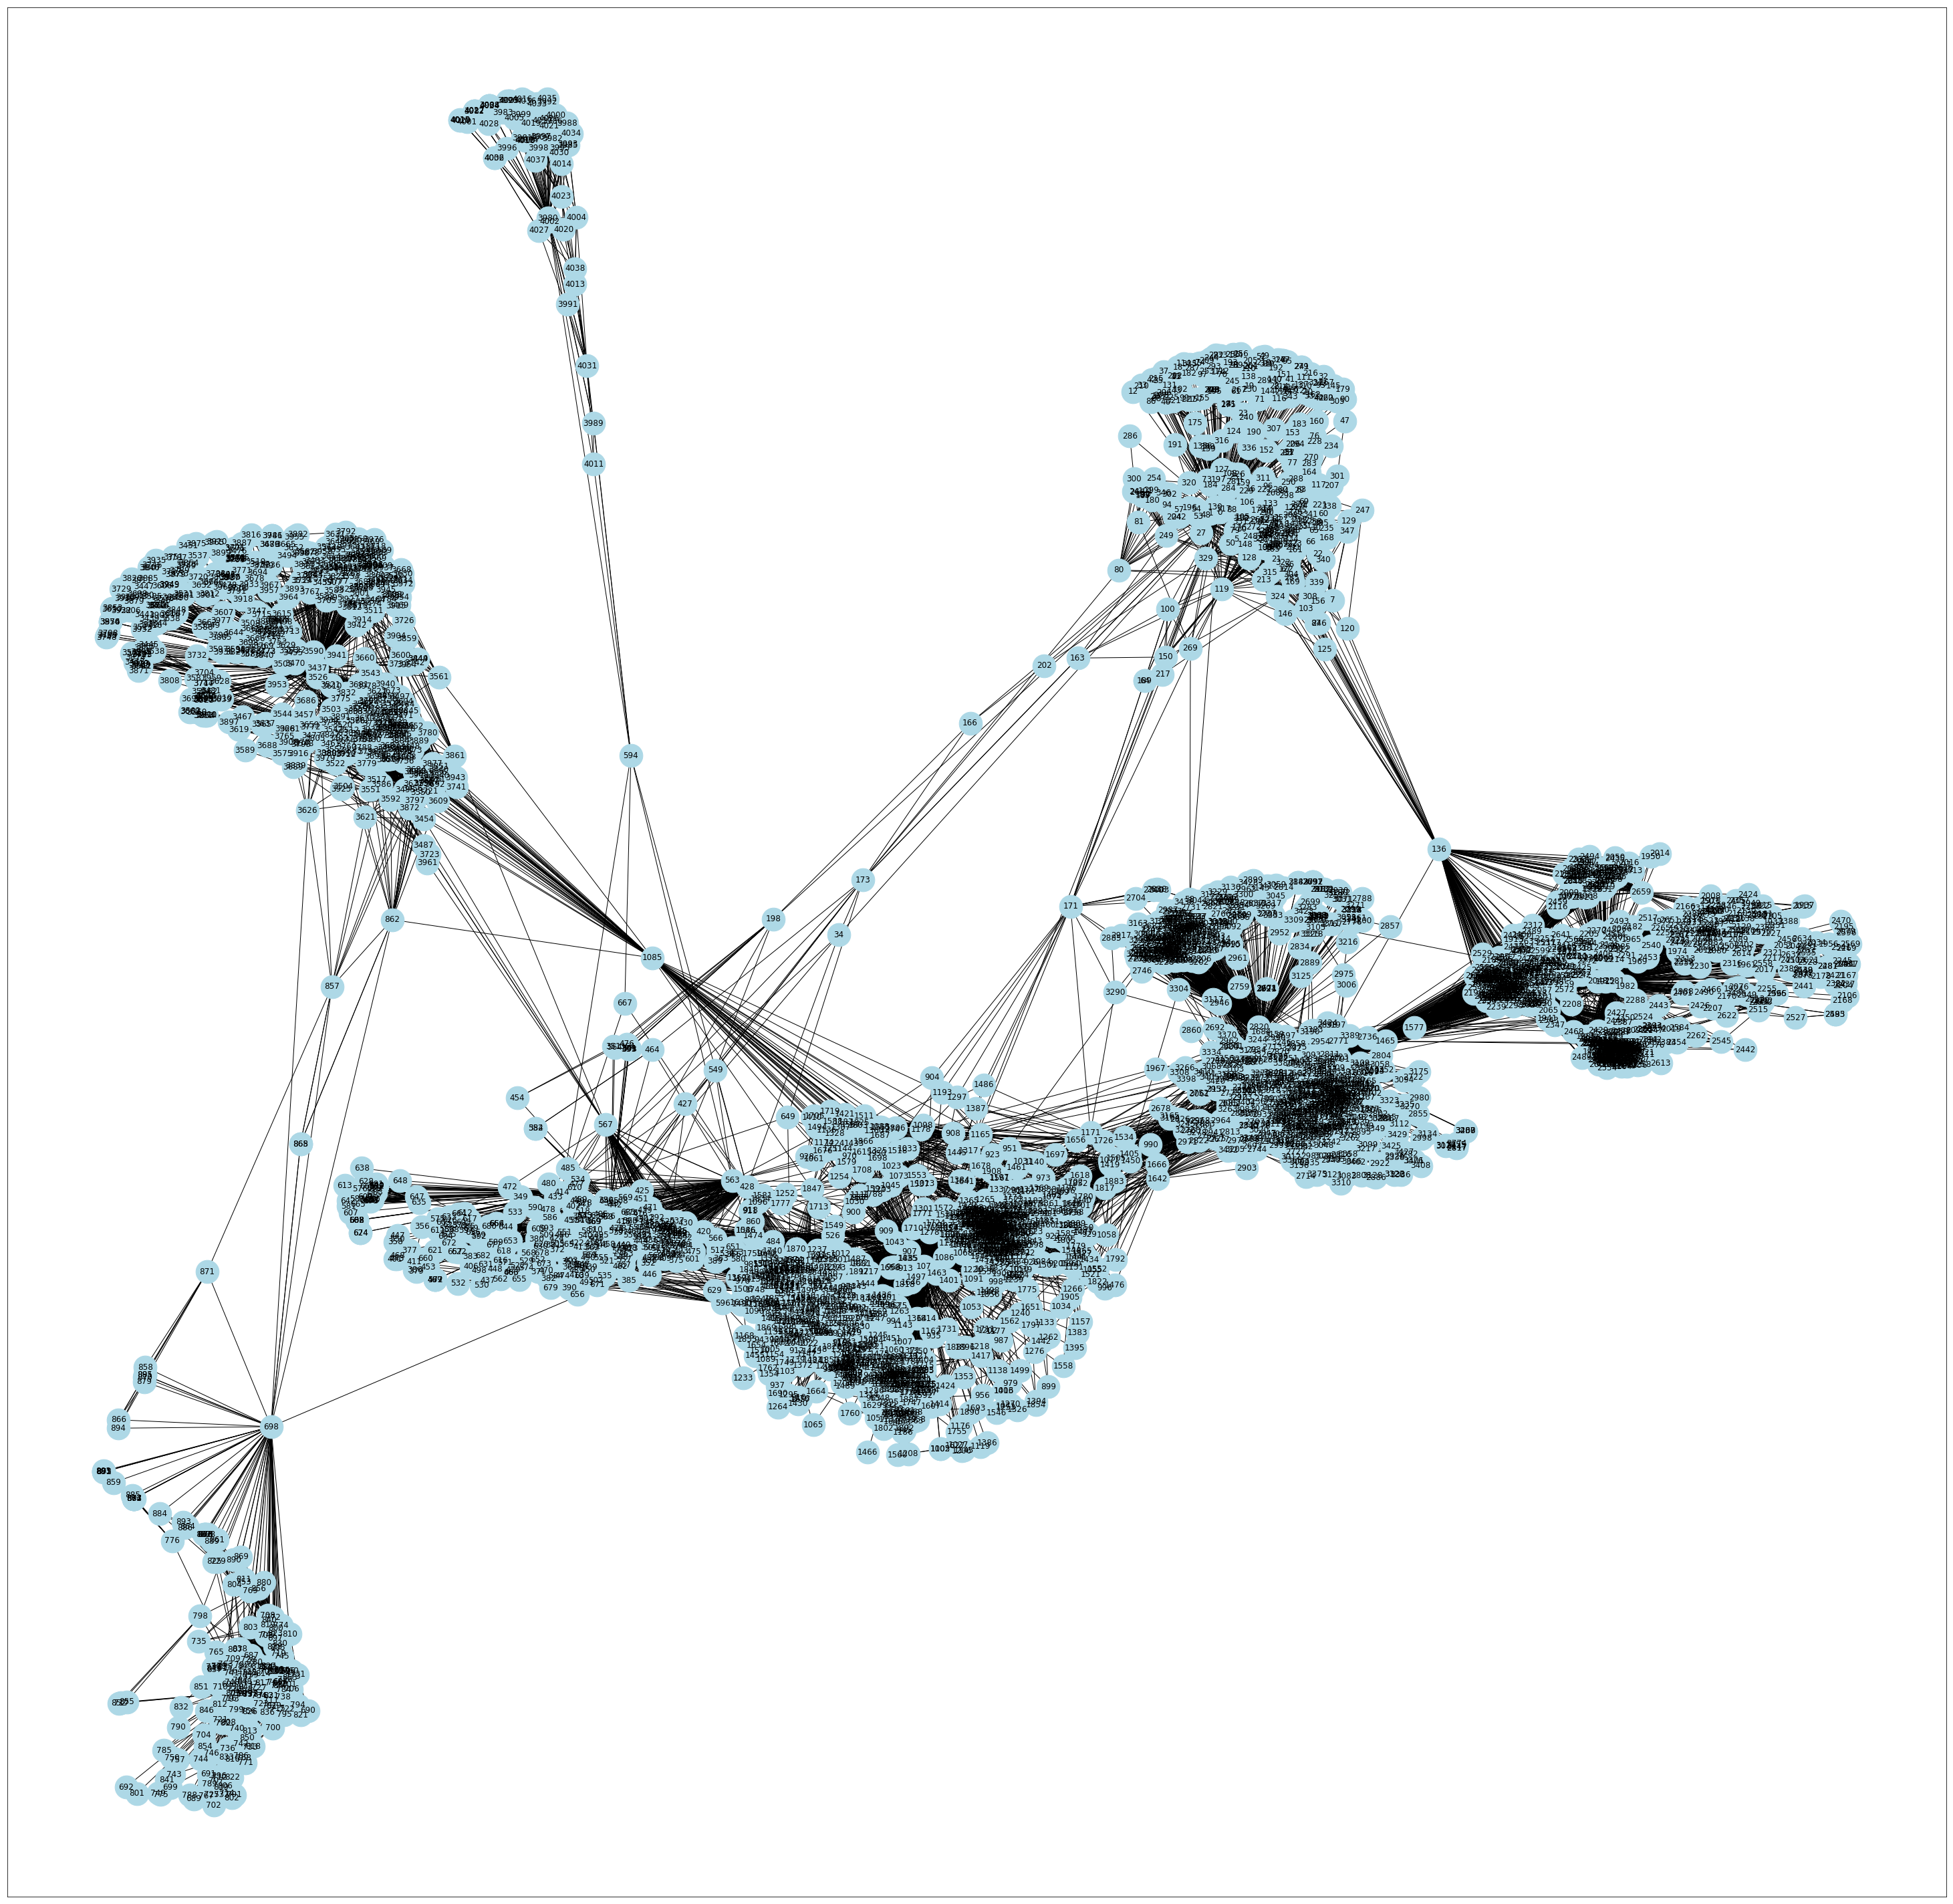

In [86]:
plt.figure(figsize=(52,52))
pos=nx.fruchterman_reingold_layout(F) 
nx.draw_networkx(F,with_labels=True,arrows=True,edge_attr=True, arrowsize=10,pos=pos,node_size=1200, node_color='lightblue')

In [78]:
main_df.sort_values(by=["bet_centrality"],ascending=False)[1:20]

nodes  deg_centrality  bet_centrality  eig_centrality birthday  \
1684   1684        0.196137        0.337797    7.164260e-06      NaN   
3437   3437        0.135463        0.236115    9.531613e-08      NaN   
1912   1912        0.186974        0.229295    9.540696e-02      NaN   
1085   1085        0.016345        0.149015    3.164082e-06      NaN   
0         0        0.085934        0.146306    3.391796e-05      NaN   
698     698        0.016840        0.115330    1.116876e-09      NaN   
567     567        0.015602        0.096310    9.932295e-06      NaN   
58       58        0.002972        0.084360    5.898120e-04      NaN   
428     428        0.028479        0.064309    5.990065e-04      NaN   
563     563        0.022536        0.062780    6.011950e-04      NaN   
860     860        0.000495        0.057826    4.601212e-08      NaN   
414     414        0.039376        0.047633    1.213415e-05        0   
1577   1577        0.042100        0.039785    7.162274e-03      NaN   
348     348        0.056711        0.037998    1.458780e-05      NaN   
1718   1718        0.038385        0.037343    4.524614e-03      NaN   
686     686        0.042100        0.029722    9.353314e-12      NaN   
594     594        0.001981        0.028803    7.497968e-06      NaN   
136     136        0.032937        0.026870    3.894375e-03      NaN   
3980   3980        0.014611        0.024820    4.722356e-08      NaN   

     education classes id education concentration id education degree id  \
1684                  NaN                        NaN                 NaN   
3437                  NaN                        NaN                 NaN   
1912                  NaN                        NaN                 NaN   
1085                  NaN                         14                  22   
0                     NaN                        NaN                 NaN   
698                   NaN                        NaN                 NaN   
567                   NaN                         15                 NaN   
58                    NaN                         14                  22   
428                   NaN                         14                 223   
563                   NaN                        NaN                 NaN   
860                   NaN                         14                 NaN   
414                   NaN                         15                 NaN   
1577                  NaN                        392                  22   
348                   NaN                        NaN                 NaN   
1718                  NaN                         18                 NaN   
686                   NaN                        NaN                 NaN   
594                   NaN                         14                  22   
136                   NaN                        NaN                 NaN   
3980                  NaN                        NaN                 NaN   

     education school id education type   ...    work location id  \
1684                 538             55   ...                 NaN   
3437                 NaN            NaN   ...                 NaN   
1912                 NaN            NaN   ...                 NaN   
1085                 538             55   ...                 619   
0                    NaN            NaN   ...                 NaN   
698                  NaN            NaN   ...                 NaN   
567                   52             55   ...                 NaN   
58                    52             55   ...                 NaN   
428                   52             55   ...                 296   
563                   52             54   ...                 NaN   
860                  NaN             55   ...                 NaN   
414                   52             55   ...                 NaN   
1577                 538             55   ...                 NaN   
348                   52             55   ...                  84   
1718     

**Create graph based on gender**

In [81]:
list_1=females.nodes
color_map = []
cmap = plt.get_cmap('Greens')
for node in F:
    if node in list_1:
        color_map.append('yellow')
    else: color_map.append('red')      

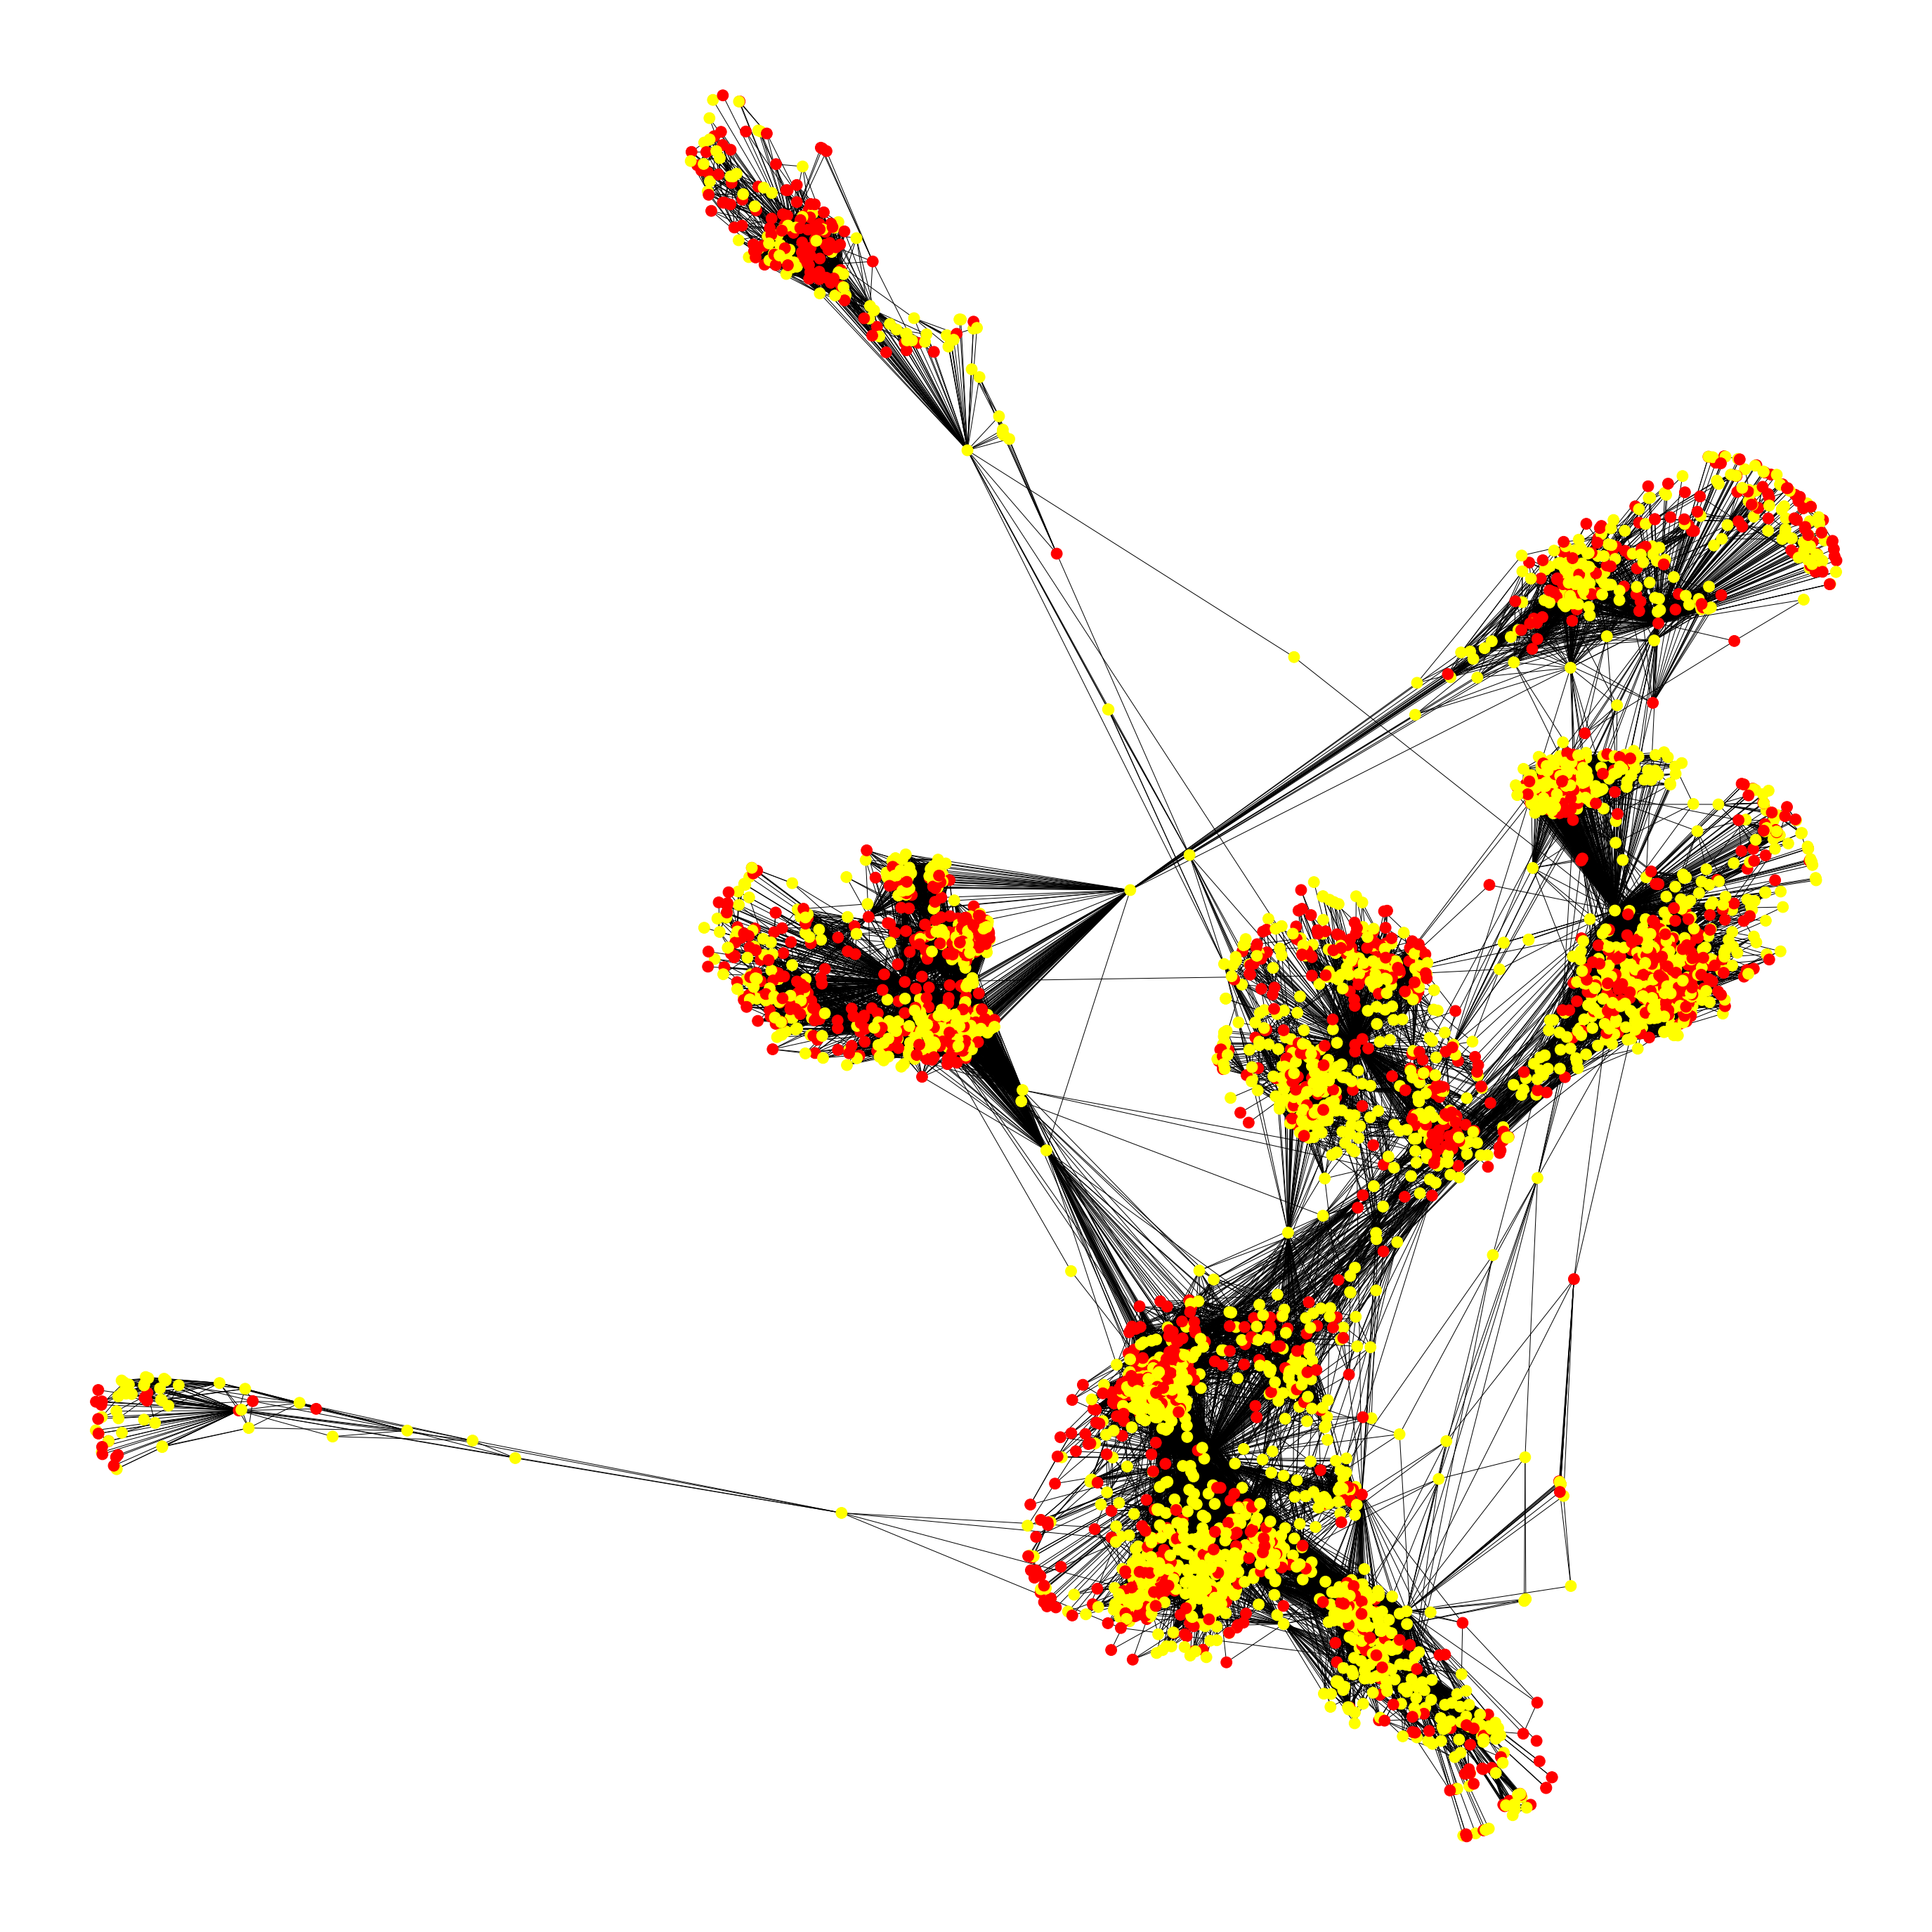

In [85]:
plt.figure(figsize=(38,38))
pos=nx.fruchterman_reingold_layout(F) 
nx.draw(F, node_color = color_map, node_size = 250)

**Graph Location nodes**
+ Below i grabbed the top 9 most repeated location nodes.  
+ The thought here is that most facebook freinds live near each other so if we color code nodes by location, we should see clustering of colors

In [73]:
list_1=main_df['location id']
list_1.value_counts(dropna=True)[1:9]

617    162
176    162
128    154
908    118
935     78
619     68
138     65
129     56
Name: location id, dtype: int64

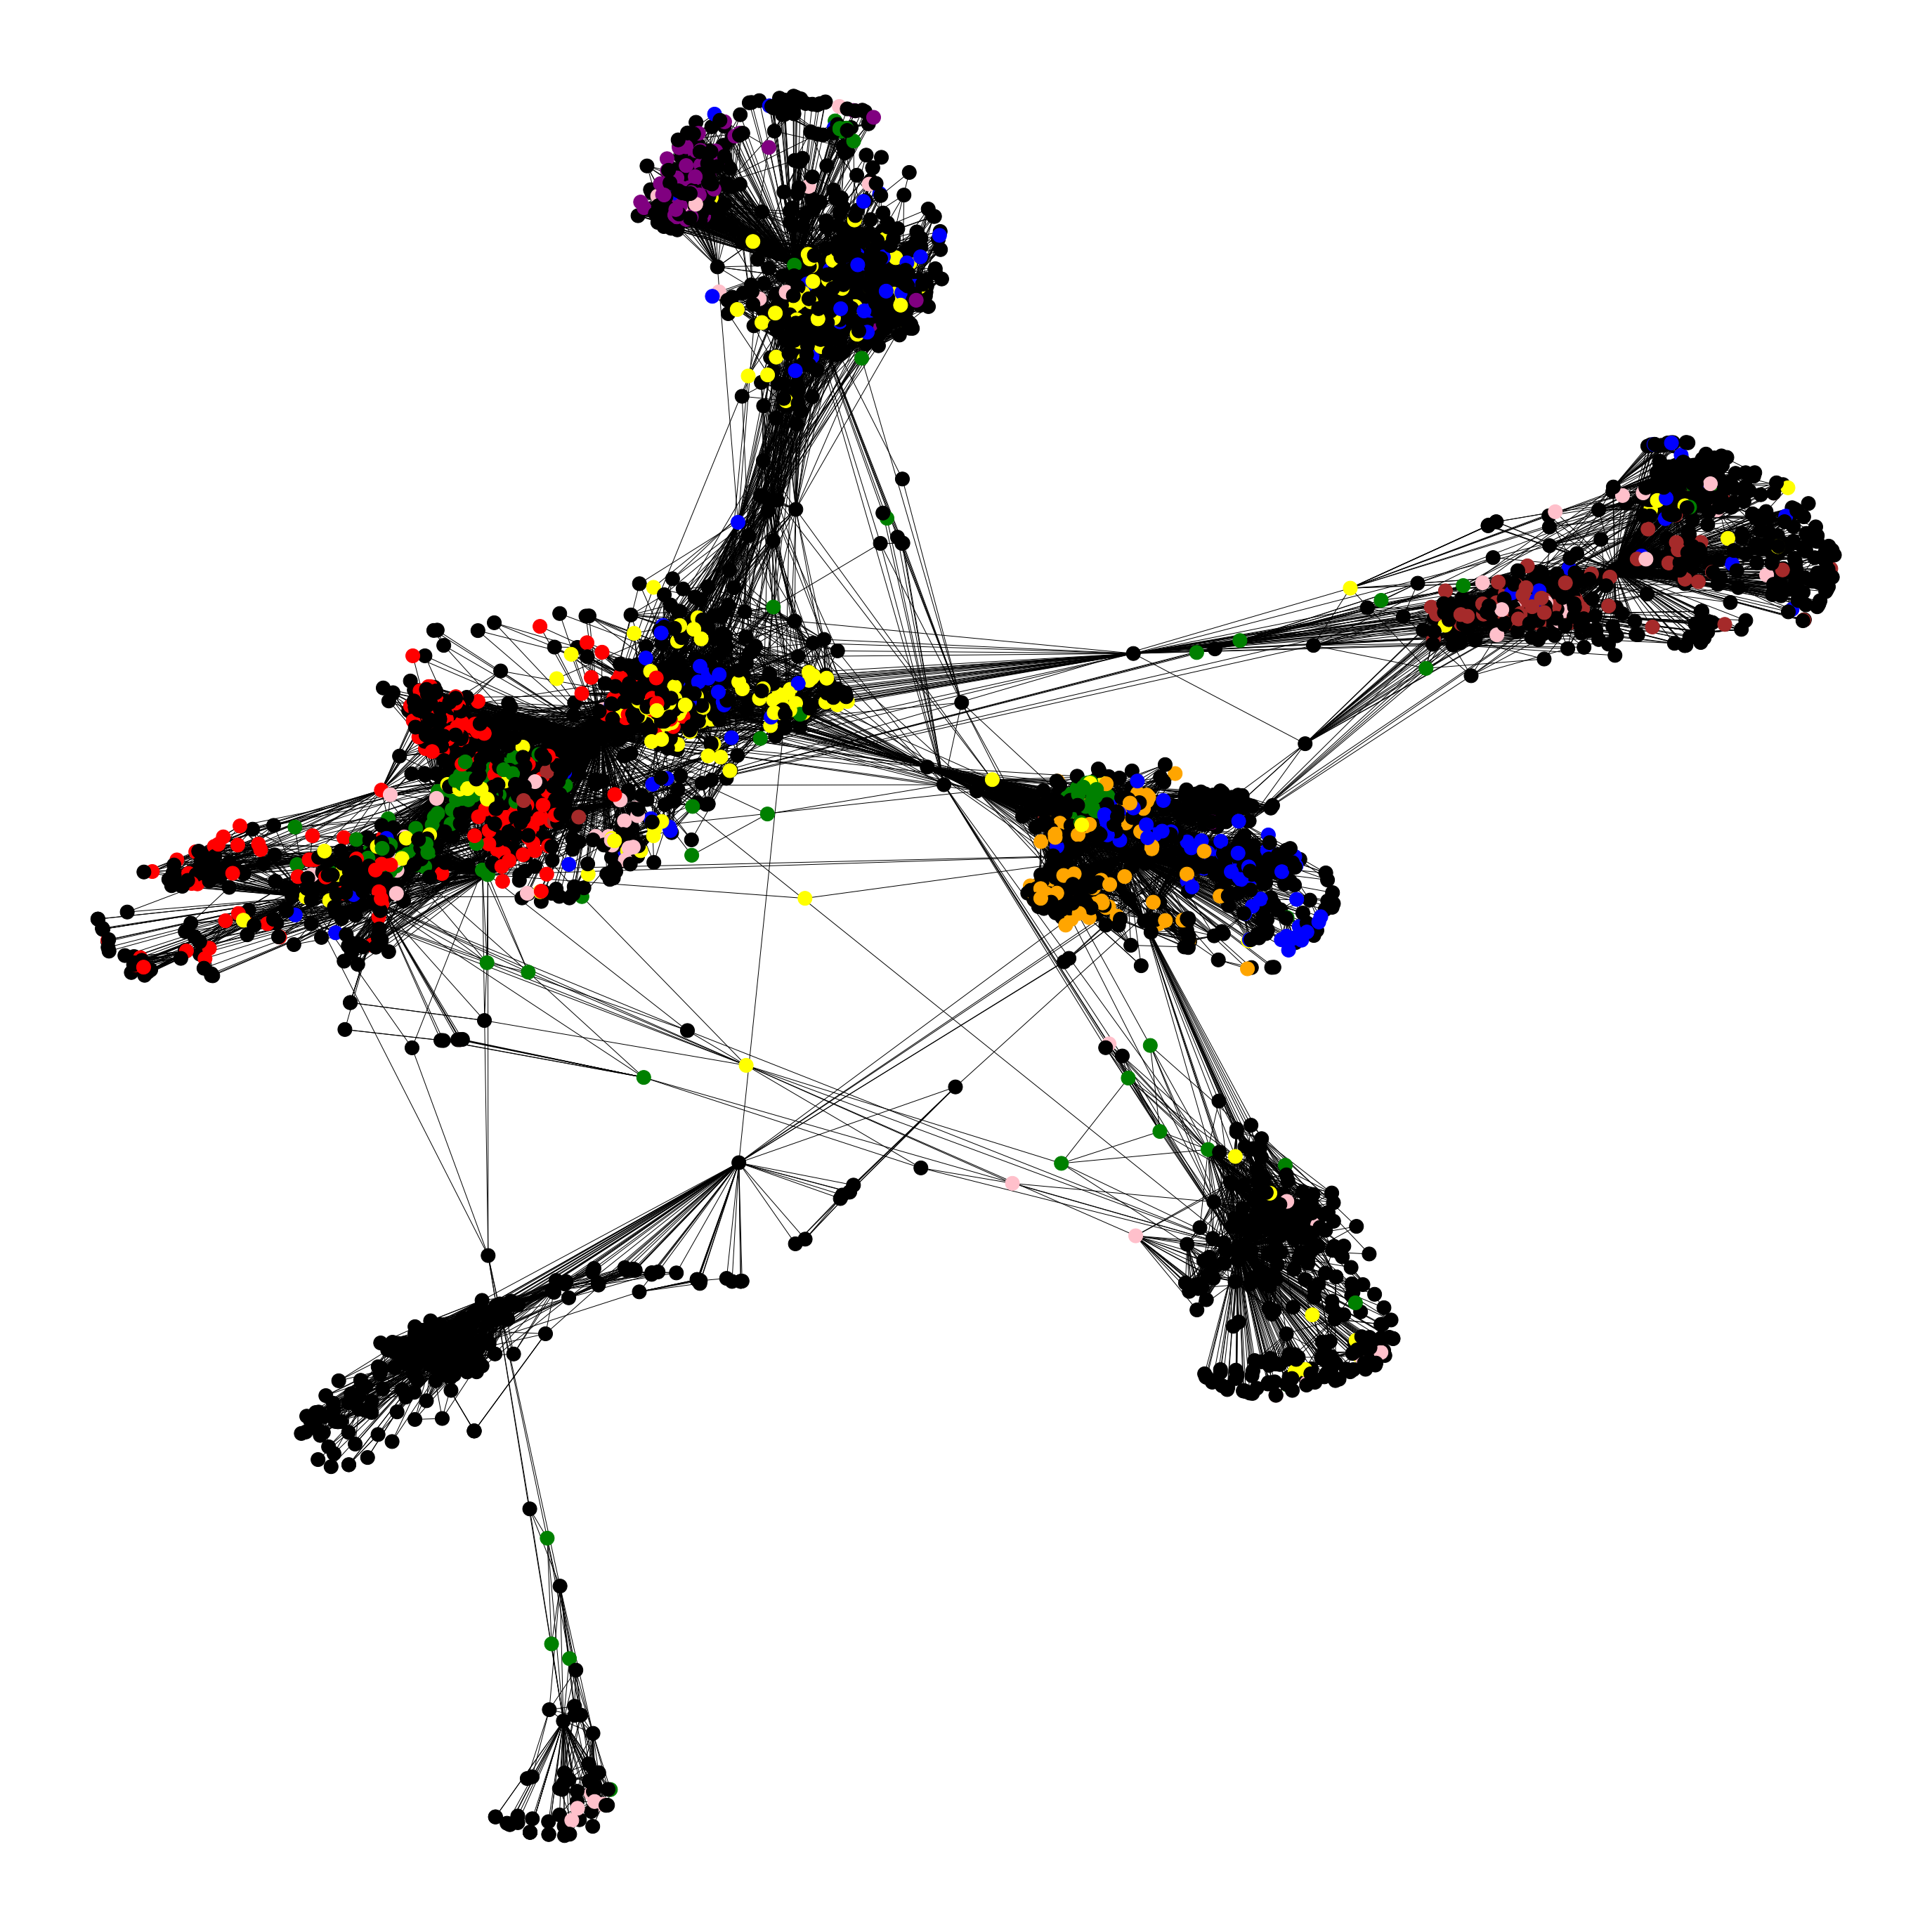

In [84]:
list_1=main_df[main_df['location id']=='84'].nodes
list_2=main_df[main_df['location id']=='617'].nodes
list_3=main_df[main_df['location id']=='176'].nodes
list_4=main_df[main_df['location id']=='128'].nodes
list_5=main_df[main_df['location id']=='908'].nodes
list_6=main_df[main_df['location id']=='935'].nodes
list_7=main_df[main_df['location id']=='619'].nodes
list_8=main_df[main_df['location id']=='138'].nodes
list_9=main_df[main_df['location id']=='129'].nodes


color_map2 = []
#cmap = plt.get_cmap('Greens')
for node in F:
    if node in list_1:
        color_map2.append('red')
    elif node in list_2:
        color_map2.append('yellow') 
    elif node in list_3:
        color_map2.append('blue') 
    elif node in list_4:
        color_map2.append('green') 
    elif node in list_5:
        color_map2.append('orange') 
    elif node in list_6:
        color_map2.append('purple') 
    elif node in list_7:
        color_map2.append('brown') 
    elif node in list_8:
        color_map2.append('pink') 
    elif node in list_9:
        color_map2.append('yellow') 
    else:
        color_map2.append('black') 
        
plt.figure(figsize=(38,38))
pos=nx.fruchterman_reingold_layout(F) 
nx.draw(F, node_color = color_map2,node_size=400)